## Load parquet

In [1]:
import logging
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pandas_ta as ta

from preprocess import preprocess_data

In [2]:
df = pd.read_parquet("3_years_500_stocks.parquet")

# Try to predict buy sell signal

## Load data

In [3]:
training_df = df[df["instrument_id"] == 318]
training_df.head()

,instrument_id,ts,open_price,close_price,high_price,low_price,volume
7521,318,2018-01-23 23:10:00+00:00,43.53,43.53,43.53,43.53,200.0
7522,318,2018-01-23 22:50:00+00:00,43.60,43.59,43.60,43.59,125.0
7523,318,2018-01-23 22:45:00+00:00,43.58,43.58,43.58,43.58,680.0
7524,318,2018-01-23 22:30:00+00:00,43.59,43.52,43.59,43.52,1649.0
7525,318,2018-01-23 22:25:00+00:00,43.59,43.58,43.59,43.58,1303.0


## Add buy sell points

### Add technical signals

In [5]:
training_df = preprocess_data(training_df)

### Add class

In [26]:
training_df.loc[:,"class"] = 0
training_df.loc[training_df["MACD_buy"],"class"] = 1
training_df.loc[training_df["MACD_sell"],"class"] = 2

### Plot signal

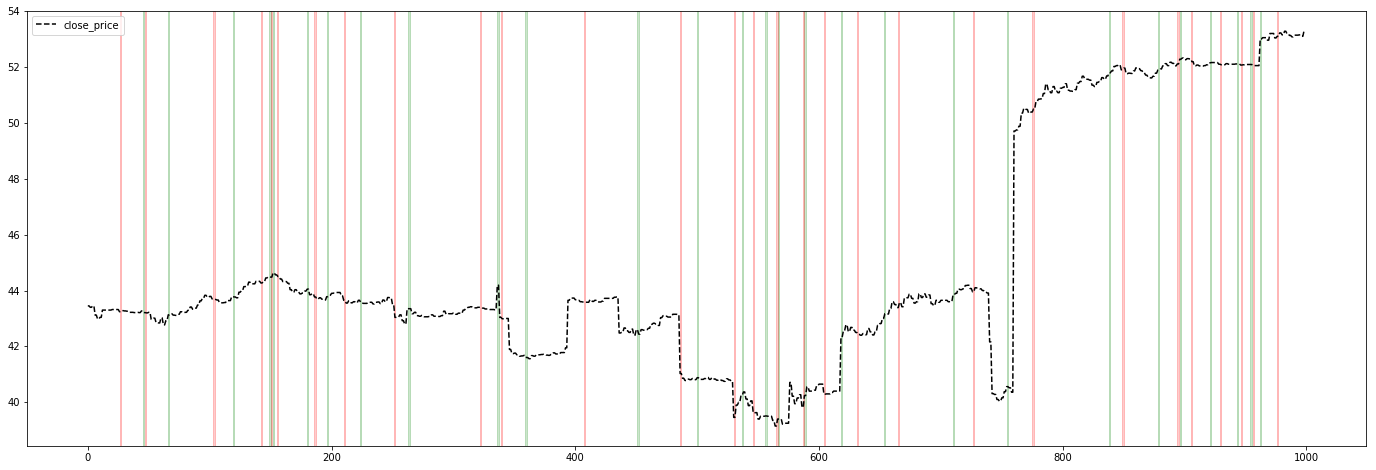

In [27]:
logging.getLogger().setLevel(logging.INFO)

plot_df = training_df.iloc[:1000]

plt.figure(figsize=(24,8))
ax = plot_df["close_price"].plot(color="black", linestyle='--')
# Show buy moments
for x in plot_df[plot_df["MACD_buy"]].index:
    ax.axvspan(x, x+1, alpha=0.2, color="green")   
# Show sell moments
for x in plot_df[plot_df["MACD_sell"]].index:
    ax.axvspan(x, x+1, alpha=0.2, color="red")   
plt.legend()

## Shift signal for prediction

## Analyze data distribution

Text(0.5, 0.98, 'Class 2 distribution')

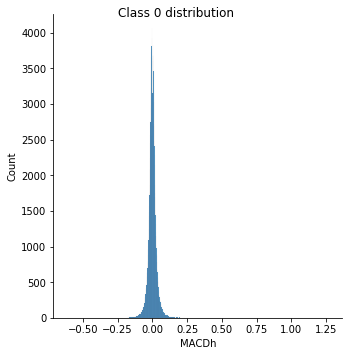

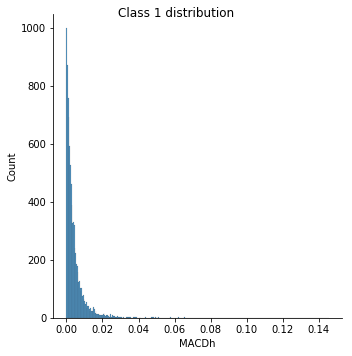

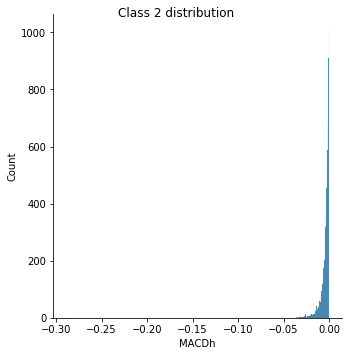

In [29]:
import seaborn as sns

class_0_df = training_df[training_df["class"] == 0]
class_1_df = training_df[training_df["class"] == 1]
class_2_df = training_df[training_df["class"] == 2]

sns.displot(class_0_df["MACDh"])
plt.suptitle("Class 0 distribution")

sns.displot(class_1_df["MACDh"])
plt.suptitle("Class 1 distribution")

sns.displot(class_2_df["MACDh"])
plt.suptitle("Class 2 distribution")


## Prepare dataset

In [49]:
# Select features
X = training_df[["MACD","MACDs","MACDh","RSI"]].values
# Normalize 
X_norm_dict = [10,10,10,110]
X /= X_norm_dict
print(X.shape)

# Select targets
Y = pd.get_dummies(training_df["class"]).values

# Y = training_df["bot_op"].values
print(Y.shape)

(214182, 4)
(214182, 3)


### Add previous data to dataset

In [52]:
window_size = 1

X_windowed = np.ndarray((X.shape[0],window_size,X.shape[1]))

for i in range(window_size,X.shape[0]):
    X_windowed[i] = X[i-window_size:i]

# Reshape
X_windowed = X_windowed.reshape(X_windowed.shape[0],X_windowed.shape[2],X_windowed.shape[1],1)
X_windowed.shape


(214182, 4, 1, 1)

### Create test and train datasets

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_windowed, Y, test_size=0.3)

### Create model

In [54]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
import tensorflow.keras as keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# Create model
model = Sequential([
    Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='sigmoid')
])

# Compiling the neural network
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

model.summary()

# Fitting the data to the training dataset
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_test, Y_test))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                160       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 27        
Total params: 451
Trainable params: 451
Non-trainable params: 0
________________________________________________________

### Plot training history

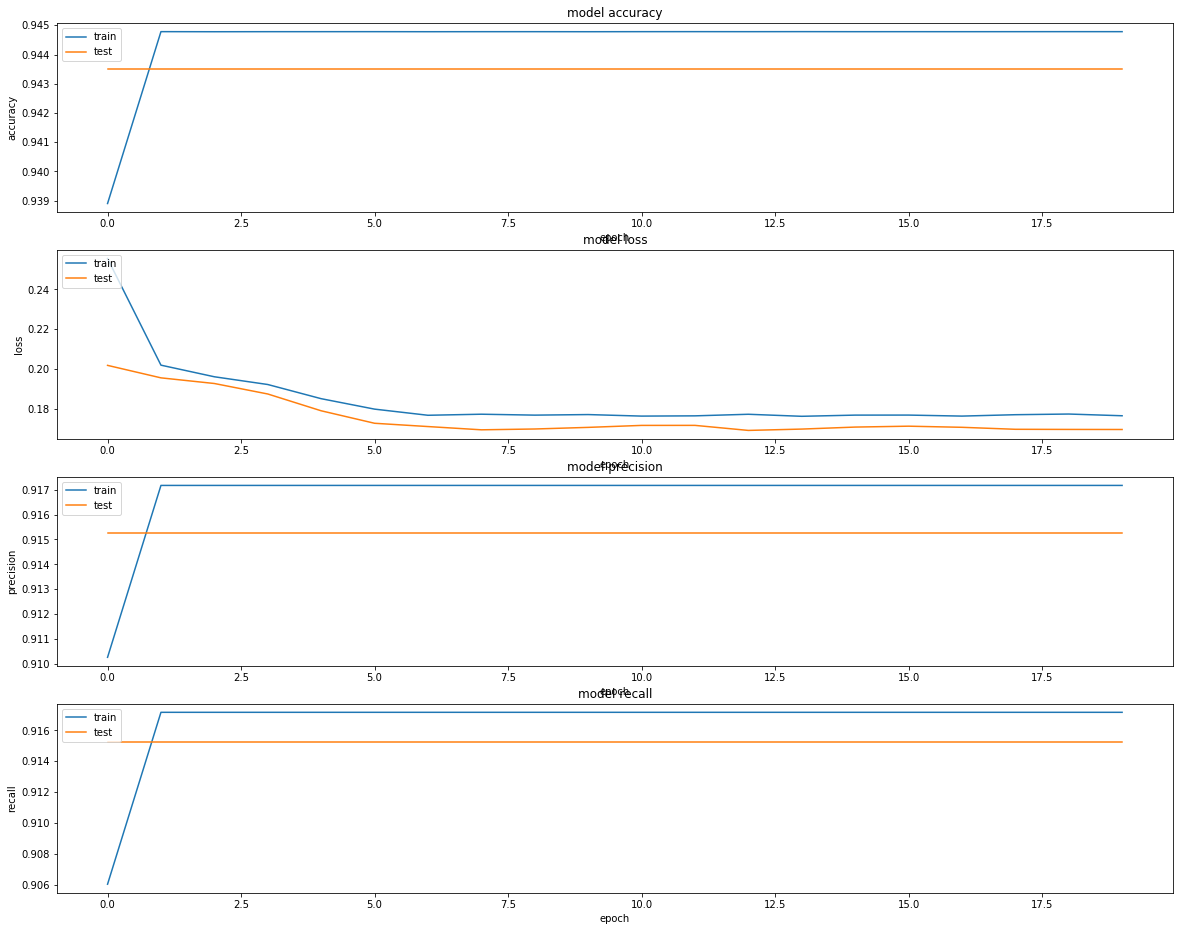

In [55]:
plt.figure(1, figsize=(20,16))  

plt.subplot(411)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

plt.subplot(412)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

plt.subplot(413)  
plt.plot(history.history['precision'])  
plt.plot(history.history['val_precision'])  
plt.title('model precision')  
plt.ylabel('precision')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

plt.subplot(414)  
plt.plot(history.history['recall'])  
plt.plot(history.history['val_recall'])  
plt.title('model recall')  
plt.ylabel('recall')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

## Make test with prediction

In [56]:
Y_pred = model.predict(X_test)

In [57]:
from sklearn.metrics import classification_report

report = classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
print(report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     58810
           1       0.00      0.00      0.00      2755
           2       0.00      0.00      0.00      2690

    accuracy                           0.92     64255
   macro avg       0.31      0.33      0.32     64255
weighted avg       0.84      0.92      0.87     64255



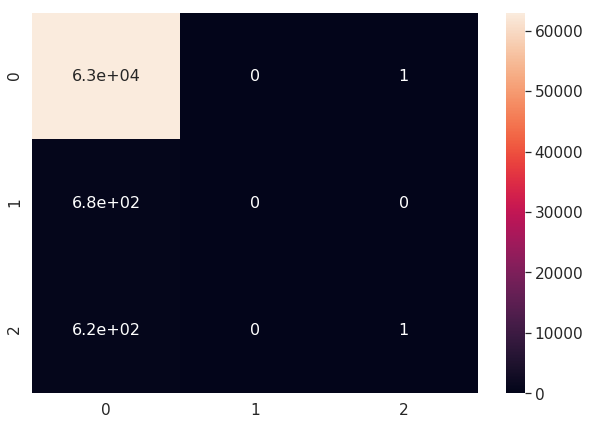

In [93]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, np.argmax(Y_pred, axis=1))

cm_df = pd.DataFrame(cm)

plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm_df, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [32]:
model.evaluate(X_test, Y_test)

2008/2008 [==============================] - 1s 502us/step - loss: 0.0964 - accuracy: 0.9798


[0.09639636427164078, 0.9797836542129517]